In [20]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [21]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 25
SIZE = 200
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [22]:
X = torch.randn(SIZE, 2, dtype=DTYPE, device='cpu')
y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + .3 * torch.randn(SIZE, dtype=DTYPE, device='cpu')

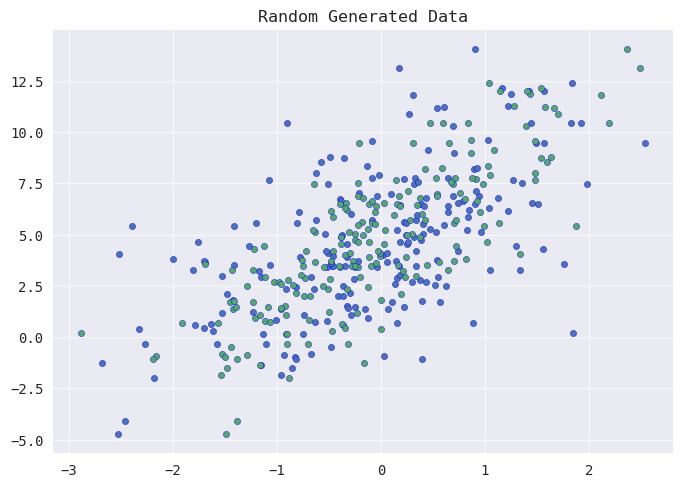

In [23]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
plt.grid(True, alpha = .6);
plt.title("Random Generated Data");
plt.show()

In [24]:
X, X.shape

(tensor([[-1.7886e+00, -3.6625e-01],
         [ 6.0863e-01,  1.5833e+00],
         [ 2.5408e+00, -2.1299e-01],
         [ 8.5142e-01, -3.3035e-01],
         [ 1.5594e+00, -1.2239e+00],
         [-2.9999e-01, -8.1893e-01],
         [-2.0929e-01,  7.5885e-01],
         [-1.8039e+00,  6.4491e-01],
         [ 1.5088e-01, -1.5632e+00],
         [-1.6911e+00,  5.5642e-01],
         [-1.4202e+00,  2.7168e-04],
         [ 1.9226e+00,  4.7216e-01],
         [ 1.7629e+00, -1.6895e+00],
         [ 6.2281e-01, -1.2883e+00],
         [ 5.3155e-01, -3.0257e-01],
         [-1.1550e+00, -1.1620e+00],
         [ 1.4564e+00, -3.3919e-01],
         [ 3.4238e-01, -7.4795e-01],
         [-1.7620e+00,  1.0223e+00],
         [ 1.2483e+00,  1.4324e+00],
         [-8.1508e-02,  4.2719e-01],
         [-2.5148e+00,  1.3360e+00],
         [ 5.5117e-01, -1.1150e+00],
         [-3.4681e-02, -5.4827e-01],
         [-1.4131e+00,  9.8710e-01],
         [-2.8335e-01,  3.9445e-01],
         [-1.2049e+00,  1.1345e+00],
 

In [25]:
y, y.shape

(tensor([ 0.5792, 11.1952,  9.4500,  6.1891,  4.3087,  2.1447,  6.9982,  3.2900,
          0.6890,  3.6709,  1.8059, 10.4455,  3.5551,  2.4808,  5.1143, -1.3431,
          6.5434,  3.4642,  4.6313, 11.8383,  5.6991,  4.0700,  2.9168,  3.3982,
          5.4041,  5.9940,  5.5531,  1.3857,  2.5368,  8.1696,  2.3434,  2.8689,
         10.4091,  5.0026,  2.6622,  3.8863,  2.8478, -0.8049, 12.1573,  4.9811,
         -0.9898,  3.4299,  8.5219,  0.1769,  5.1303,  5.2298,  3.7446,  4.2011,
          6.4870,  0.3086,  9.4747, -0.8795,  4.9822,  3.3939,  9.5429,  0.6175,
          8.0097,  5.6947,  4.7244, -1.0455,  3.8254,  6.4504, 10.4472,  7.7117,
          4.4484,  6.8787,  0.7999,  6.6543,  3.9216,  7.7389,  3.9737, -4.7225,
          6.5305,  2.9445,  1.7183, 13.1140,  2.7781,  0.8263,  4.0191, -1.2700,
          3.2854,  8.2397,  8.7511,  4.1943,  3.4437,  0.4349,  0.4119,  5.6278,
          4.0764,  3.6861, -0.3297,  8.3502,  4.5426,  7.7385,  4.5586,  1.5141,
          6.1671,  3.4756,  

In [26]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[-1.7886e+00, -3.6625e-01],
         [ 6.0863e-01,  1.5833e+00],
         [ 2.5408e+00, -2.1299e-01],
         [ 8.5142e-01, -3.3035e-01],
         [ 1.5594e+00, -1.2239e+00],
         [-2.9999e-01, -8.1893e-01],
         [-2.0929e-01,  7.5885e-01],
         [-1.8039e+00,  6.4491e-01],
         [ 1.5088e-01, -1.5632e+00],
         [-1.6911e+00,  5.5642e-01],
         [-1.4202e+00,  2.7168e-04],
         [ 1.9226e+00,  4.7216e-01],
         [ 1.7629e+00, -1.6895e+00],
         [ 6.2281e-01, -1.2883e+00],
         [ 5.3155e-01, -3.0257e-01],
         [-1.1550e+00, -1.1620e+00],
         [ 1.4564e+00, -3.3919e-01],
         [ 3.4238e-01, -7.4795e-01],
         [-1.7620e+00,  1.0223e+00],
         [ 1.2483e+00,  1.4324e+00],
         [-8.1508e-02,  4.2719e-01],
         [-2.5148e+00,  1.3360e+00],
         [ 5.5117e-01, -1.1150e+00],
         [-3.4681e-02, -5.4827e-01],
         [-1.4131e+00,  9.8710e-01],
         [-2.8335e-01,  3.9445e-01],
         [-1.2049e+00,  1.1345e+00],
 

In [27]:
Model = LinearRegression(in_dims=2).to(DEVICE)

In [28]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.L1Loss(reduction='mean'),
    device=DEVICE
)

In [30]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([ 0.2684, -0.3284], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.5805], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.2854, -0.3391], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.4805], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.3306, -0.3393], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.4055], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.3008, -0.3507], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.3118], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.3389, -0.3159], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.2180], device='cuda:0')
Epoch 1/25 | Loss: 5.2355
	| Validation Loss: 4.9648

	Epoch 2 | Weights: tensor([ 0.3495, -0.3210], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.1243], device='cuda:0')
	Epoch 2 | Weights: tensor([ 0.3651, -0.3064], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.0305], device='cuda:0')
	Epoch 2 | Weights: tensor([ 0.3773, -0.2790], device='cuda:0')
	Epoch 2 | Bias: tensor([0.0570], device='cuda:0')
	Epoch 2 | Weights:

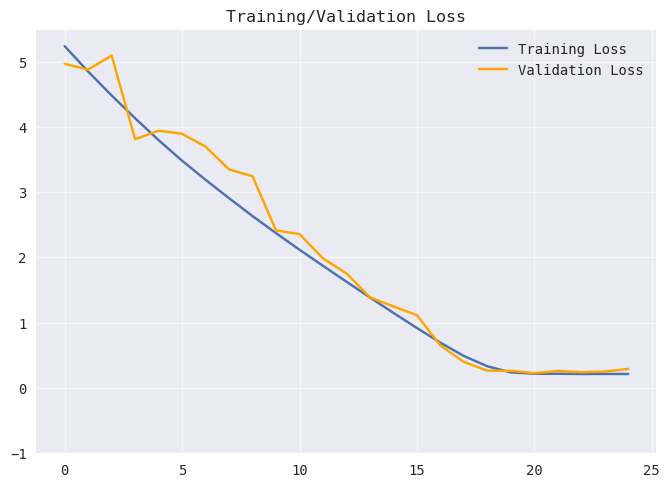

In [31]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=-1)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [32]:
# y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')
print(
    f"Trained Weights: {Model.w.data}",
    f"Trained Bias: {Model.b.data}",
    sep="\n"
)

Trained Weights: tensor([2.0244, 3.0298], device='cuda:0')
Trained Bias: tensor([5.0007], device='cuda:0')


In [33]:
# Analytical Solution
# First, bias must be added to the design matrix
X = torch.tensor(np.concatenate([X, np.ones((SIZE, 1))], axis=1), dtype=DTYPE, device='cpu')

w = torch.linalg.inv(X.T @ X) @ X.T @ y
print(f"Analytical Solution for Weights: {w}")

Analytical Solution for Weights: tensor([2.0322, 3.0169, 4.9932])


In [34]:
T = np.linspace(X.min(), X.max(), SIZE, dtype=np.float32).reshape(SIZE, 1)
T = torch.tensor(np.concatenate([T, T], axis=1), device=DEVICE)

# Inference
with torch.no_grad():
    yT = Model(T)

print(f"\nGenerated T:\n{T}")
print(f"\nPredictions:\n{yT}")


Generated T:
tensor([[-2.8807, -2.8807],
        [-2.8535, -2.8535],
        [-2.8263, -2.8263],
        [-2.7990, -2.7990],
        [-2.7718, -2.7718],
        [-2.7445, -2.7445],
        [-2.7173, -2.7173],
        [-2.6900, -2.6900],
        [-2.6628, -2.6628],
        [-2.6355, -2.6355],
        [-2.6083, -2.6083],
        [-2.5811, -2.5811],
        [-2.5538, -2.5538],
        [-2.5266, -2.5266],
        [-2.4993, -2.4993],
        [-2.4721, -2.4721],
        [-2.4448, -2.4448],
        [-2.4176, -2.4176],
        [-2.3904, -2.3904],
        [-2.3631, -2.3631],
        [-2.3359, -2.3359],
        [-2.3086, -2.3086],
        [-2.2814, -2.2814],
        [-2.2541, -2.2541],
        [-2.2269, -2.2269],
        [-2.1996, -2.1996],
        [-2.1724, -2.1724],
        [-2.1452, -2.1452],
        [-2.1179, -2.1179],
        [-2.0907, -2.0907],
        [-2.0634, -2.0634],
        [-2.0362, -2.0362],
        [-2.0089, -2.0089],
        [-1.9817, -1.9817],
        [-1.9545, -1.9545],
      

In [35]:
T.shape, yT.shape

(torch.Size([200, 2]), torch.Size([200]))

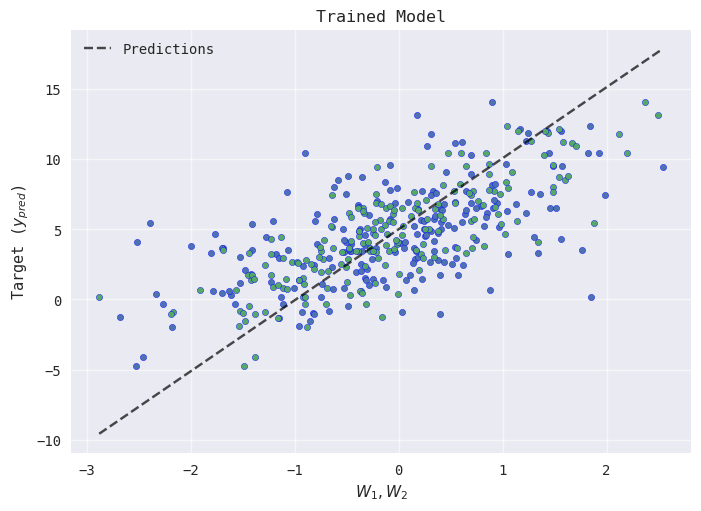

In [36]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
# Predicted Linear Model
plt.plot(T[:, 0].cpu().numpy(), yT.cpu().numpy(), color="black", alpha=.7, linestyle='--', label="Predictions");
plt.grid(True, alpha = .6);
plt.title("Trained Model");
plt.xlabel("$W_1, W_2$");
plt.ylabel("Target ($y_{pred}$)");
plt.legend(loc='best');
plt.show()